# Hypergraph exploration - recipes example - JointVectorLabelLayers

The goal of this notebook is to use the tools in the Tutte Institute [``vectorizers``](https://github.com/TutteInstitute/vectorizers) and [``thisnotthat``](https://github.com/TutteInstitute/thisnotthat) libraries to construct hypergragh embeddings. 

We will jointly embed vertices and hyperedges in the same space and use JointVectorLabelLayers to obtained an automatic labelling of hyperedge clusters based on their proximities to the vertices' vectors. 

We will make use of a recipe dataset. After filtering out recipes having two ingredients or less (see data-setup), the data consists of 39,559 recipes (hyperedges) and 6,714 ingredients (vertices). The largest recipe has 65 ingredients (must be good!). Each recipe is assigned to a country (edge label), with 20 countries total. The data and some work done with it can be found here:

* https://arxiv.org/pdf/1910.09943.pdf
* https://www.cs.cornell.edu/~arb/data/cat-edge-Cooking/

### Setup

To create the environment:

* mamba env create -f hypergraphs-simple.yml

or

* conda create -n hypergraphs-simple numba datashader jupyter ipykernel
* conda activate hypergraphs-simple
* pip install thisnotthat seaborn igraph hypernetx

In [1]:
import thisnotthat as tnt
import panel as pn

import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import csv

In [2]:
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
from scipy.sparse import vstack
import warnings
      
warnings.simplefilter("ignore")
sns.set()

In [3]:
from IPython.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data preparation

We will make use of the recipe dataset. It consists of 39,774 recipes (hyperedges) that are sets of vertices (6,714 ingredients total). The largest recipe has 65 ingredients (must be good!). Each recipe is assigned to a country (edge label), 20 countries total. The data and some work done with it can be found here:

This function 
* reads the data
* keeps only the recipes containing at least 3 ingredients (after this pruning we are left with 6,714 ingredients and 39,559 recipes)
* chooses a country color mapping that respects countries' proximities, or continent - nearby countries are assigned to similar colors. This is to help with the eye-ball evaluation of the visualization and make it more pleasant.

In [4]:
data_folder = '../data/cat-edge-Cooking/'

In [5]:
def read_format_recipes(recipe_min_size=3, data_folder=data_folder):
    ingredients_id = pd.read_csv(f'{data_folder}node-labels.txt', sep='\t', header=None)
    ingredients_id.index = [x+1 for x in ingredients_id.index]
    ingredients_id.columns = ['Ingredient']
    
    recipes_with_id = []
    with open(f'{data_folder}hyperedges.txt', newline = '') as hyperedges:
        hyperedge_reader = csv.reader(hyperedges, delimiter='\t')
        for hyperedge in hyperedge_reader:
            recipes_with_id.append(hyperedge)
            
    recipes_all = [[ingredients_id.loc[int(i)]['Ingredient'] for i in x] for x in recipes_with_id]
    
    # Keep recipes with 3 ingredients and more
    keep_recipes = np.where(np.array([len(x) for x in recipes_all])>=recipe_min_size)[0]
    recipes = [recipes_all[i] for i in keep_recipes]
    
    recipes_label_id_all = pd.read_csv(f'{data_folder}hyperedge-labels.txt', sep='\t', header=None)
    recipes_label_id_all.columns = ['label']
    recipes_label_id = recipes_label_id_all.iloc[keep_recipes].reset_index()

    label_name = pd.read_csv(f'{data_folder}hyperedge-label-identities.txt', sep='\t', header=None)
    label_name.columns = ['country']
    label_name.index = [x+1 for x in label_name.index]
    
    grps_tmp = {
        'asian' : ('chinese', 'filipino', 'japanese','korean', 'thai', 'vietnamese'),
        'american' : ('brazilian', 'mexican', 'southern_us'),
        'english' : ('british', 'irish'),
        'islands' : ('cajun_creole', 'jamaican'),
        'europe' : ('french', 'italian', 'spanish'),
        'others' : ('greek', 'indian', 'moroccan', 'russian')
    }

    grps = {key:[key+'.'+x for x in value] for key, value in grps_tmp.items()}


    color_key = {}
    for l, c in zip(grps['asian'], sns.color_palette("Blues", 6)[0:]):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    for l, c in zip(grps['american'], sns.color_palette("Purples", 4)[1:]):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    for l, c in zip(grps['others'], sns.color_palette("YlOrRd", 4)):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    for l, c in zip(grps['europe'], sns.color_palette("light:teal", 4)[1:]):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    for l, c in zip(grps['islands'], sns.color_palette("light:#660033", 4)[1:3]):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    for l, c in zip(grps['english'], sns.color_palette("YlGn", 4)[1:]):
        color_key[l] = matplotlib.colors.rgb2hex(c)
    color_key["ingredient"] = "#777777bb"
    
    new_names = []
    for key, value in grps.items():
        new_names = new_names + value

    label_name['new_label'] = [new_name for x in label_name.country for new_name in new_names if x in new_name]
    
    return(recipes, recipes_label_id, ingredients_id, label_name, color_key)

In [6]:
# execfile('./00-recipes-setup.py')
recipes, recipes_label_id, ingredients_id, label_name, color_key = read_format_recipes()
recipes_label = [label_name.loc[i]['new_label'] for i in recipes_label_id.label]
recipes_country = [label_name.loc[i]['country'] for i in recipes_label_id.label] 

# Build vertex (ingredient) vectors

We first build a vector representation of ingredients based on co-occurrences of vertices in the same hyperedges. Little hack here: we make our own. We use our own as the current vectorizer library has a cooccurrence vectorizer based on ordered hyperedges and so has concepts such as "appears before" or "appears after" that we wish to avoid.

The vector representations of the vertices are rows of the weighted adjacency matrix of the hypergraph's 2-section.
From the incidence matrix $H$ (number of vertices x number of hyperedges), this can be obtained via $V_{vectors} = H^TH - D_e$ where $D_e$ is the diagonal matrix that contains the hyperedge sizes. From experiments, we obtain better results by row and column normalizing and reducing the dimensionality of this vertex representation using SVD. Experiments on documents, also show that we get improvements by taking the $4^{th}$ root entry-wise of the normalized matrices before reducing dimensionality. We do the same here because it works well, but it has not been tested on hypergraphs.

In [7]:
def vertexCooccurrenceVectorizer(hyperedges):
    vertexCooccurrence_vectorizer = vectorizers.TokenCooccurrenceVectorizer().fit(hyperedges)
    
    incidence_vectorizer = vectorizers.NgramVectorizer(
        token_dictionary=vertexCooccurrence_vectorizer.token_label_dictionary_
    ).fit(hyperedges)

    H = incidence_vectorizer.transform(hyperedges)
    
    M_cooccurrence = (H.T@H)
    M_cooccurrence.setdiag(0)
    M_cooccurrence.eliminate_zeros()
    
    vertexCooccurrence_vectorizer.cooccurrences_ = M_cooccurrence
    
    return(vertexCooccurrence_vectorizer)

In [8]:
%%time

ingredient_vectorizer = vertexCooccurrenceVectorizer(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")
n_ingredients = len(ingredient_vectorizer.token_index_dictionary_)
ingredients = [ingredient_vectorizer.token_index_dictionary_[i] for i in range(n_ingredients)]

CPU times: total: 26.7 s
Wall time: 37.4 s


# Build hyperedge (recipe) vectors

In order to build hyperedge vectors, we will be treating each edge as a distribution over the vertex space. Instead of considering flat distributions of vertices contained in the hyperedges, we use a distribution given by the information weighted incidence matrix. In this incidence matrix, each vertex row gets multiplied by a weight: the information gain of the vertex' observed distribution over hyperedges
$$P_v(e) = \begin{cases}
1/deg(v) &\text{if $v \in e$}\\
0 &\text{otherwise}
\end{cases}
$$  compared to a baseline distribution based of hyperedge sizes $Q(e) = \frac{|e|}{\sum |e|}.$ The weights are computed as follows:

$$\mbox{Info}(v) = \sum_e P_v(e) \log\big(\frac{P_v(e)}{Q(e)}\big)= C - \frac{1}{deg(v)}\sum_{e: v \in e} (|e|\cdot deg(v)).$$
In the case of hyperedges, this will tend to give more weights to vertices that appear in smaller hyperedges and less weights to vertices that appear in all hyperedges.

This is done in two steps: (1) construct the incidence matrix, (2) transform it into its information weighted version.

In [9]:
%%time
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit(recipes)

incidence_matrix = incidence_vectorizer.transform(recipes)

CPU times: total: 5.42 s
Wall time: 5.8 s


In [10]:
%%time
info_weighted_incidence = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(incidence_matrix)

CPU times: total: 2.33 s
Wall time: 3.57 s


# Joint embedding of vertices and hyperedges

We now have a vector representation for each vertex, and we treat hyperedges as distribution over that space. We can also treat vertices themselves as distributions: a vertex is the Dirac Delta distribution having all mass on its itself (its associated vector).

Now, both vertices and hyperedges are seen as distributions over a vector space. We can now use the Approximate Wasserstein vectorizer. This vectorizer transforms finite distributions over a metric space into vectors in a linear space such that euclidean or cosine distance approximates the Wasserstein distance between the distributions. 

This is done by representing the vertex distributions with the identity matrix on the vertices, and stacking the weighted incidence with this identity matrix. Then give this matrix of both hyperedge and node distributions to the vectorizer function along with the vertex vectors.

In [11]:
info_doc_with_identity = vstack([info_weighted_incidence, scipy.sparse.identity(n_ingredients)])

In [12]:
%%time
joint_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.25,
    random_state=42,
).fit_transform(info_doc_with_identity, vectors=ingredient_vectors)

CPU times: total: 2.91 s
Wall time: 1.2 s


In [13]:
%%time
joint_vectors_mapper = umap.UMAP(metric="cosine", random_state=42).fit(joint_vectors_unsupervised)

CPU times: total: 1min 42s
Wall time: 1min 46s


# This not that : explore hypergraph

### Build dataframe that contains information about vertex and hyperedges

In [14]:
recipe_metadata = pd.DataFrame()
recipe_metadata['Country'] = recipes_country
recipe_metadata['Label'] = recipes_label
recipe_metadata['Ingredients'] = recipes 
recipe_metadata['Recipe_size'] = [len(x) for x in recipes] 

In [15]:
recipe_metadata

,Country,Label,Ingredients,Recipe_size
0,greek,others.greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,american.southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,asian.filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,others.indian,"[water, vegetable oil, wheat, salt]",4
4,indian,others.indian,"[black pepper, shallots, cornflour, cayenne pe...",20
...,...,...,...,...
39554,irish,english.irish,"[light brown sugar, granulated sugar, butter, ...",12
39555,italian,europe.italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",7
39556,irish,english.irish,"[eggs, citrus fruit, raisins, sourdough starte...",12
39557,chinese,asian.chinese,"[boneless chicken skinless thigh, minced garli...",21


### Select the proper vectors to plot

In [16]:
# Just plot the recipes
n_recipes = len(recipes)
recipes_bool = np.array([True for i in range(n_recipes)] + [False for i in range(n_ingredients)])
ingredients_bool = ~recipes_bool
recipe_umap = joint_vectors_mapper.embedding_[recipes_bool]

In [17]:
# Remove the ingredient from the color map as we are not plotting ingredient vectors
color_mapping = color_key.copy()
del color_mapping['ingredient']

In [18]:
# Resize the hyperedge points in terms of the recipe size (this is not very useful in this case as all recipes are of similar sizes)
sizes = [np.sqrt(len(x)) / 100 for x in recipes]

### Add a legend : legend

In [19]:
legend = tnt.LegendWidget(
    recipe_metadata.Label,
    factors=list(color_mapping.keys()), 
    palette=list(color_mapping.values()), 
    palette_length=len(color_mapping),
    color_picker_height=16,
    color_picker_margin=[0,0],
    label_height=30,
    label_width=150,
    name="Legend",
    selectable=True,
)

### Search capability : search_pane
This will allow to search the dataframe rows and have the matching rows selected and displayed on the plot.

In [20]:
search_pane = tnt.SearchWidget(recipe_metadata, width=400, title="Advanced Search")

### Summarize selection : count_summary
Counts how many things we select

In [21]:
from thisnotthat.summary.dataframe import JointLabelSummarizer, CountSelectedSummarizer
count_summary = tnt.DataSummaryPane(CountSelectedSummarizer(),sizing_mode = "stretch_width")

### Summarize selection : count_summary
First time we use the vertex vectors. This summarizer will give us the names of the closest vertex vectors to the centroid of a selection of hyperedges on the plot. This is only possible because the vertex and the hyperedges live in a common space. It will list the names along with a distance to the centroid point.

In [22]:
word_summary = JointLabelSummarizer(joint_vectors_unsupervised[recipes_bool],
                                    ingredients, 
                                    joint_vectors_unsupervised[ingredients_bool])
vertex_summary_pane = tnt.DataSummaryPane(word_summary)

### Information on click : info_pane
We will display the ingredient list on click.

In [23]:
markdown_template = """## Recipe from {Label}
---
#### Ingredients

{Ingredients}

---
"""

In [24]:
info_pane = tnt.InformationPane(recipe_metadata, markdown_template, width=400, height=750, sizing_mode="stretch_height")

In [25]:
pn.extension()

### Link everything to the plot

# Add automatic labels

This part is very interesting! We have now a way to plot recipes, filter them by country, search and interact with the data this way. We also have a way to get an overview of what a selection contains by listing its most central vertices' names. In a real unsuppervised application, the labels (the countries) would not be known. We would want to explore the recipe space and see how things organize only based on ingredient names and recipes, only on vertex name and hyperedges. 

Ingredients -vertex- vectors have been used to describe manual selections of hyperedges on the plot. Could the description be done automatically from a natural grouping of the points? The *JointVectorLabelLayers* uses the vertex names to inform and help understand the hypergraph. It builds hierarchical clusters of the hyperedges - so clusters that are displayed at various resolutions. Since hyperedge vectors jointly live with vertex vectors, for each cluster, it identifies the vertex vectors that are the closest to its centroid. The automatic labelling will display those vertex names on top of the hyperedge clusters in the plot.   

In [26]:
label_layers =  tnt.JointVectorLabelLayers(
    joint_vectors_unsupervised[recipes_bool],      # high dim edge embedding
    recipe_umap,                                   # 2-d edge embedding
    joint_vectors_unsupervised[ingredients_bool],  # high dim vertex embedding
    incidence_vectorizer.column_index_dictionary_, # vertex name
    cluster_map_representation=True,
    min_clusters_in_layer=5,
    random_state=0,
)

In [27]:
annotated_plot = tnt.BokehPlotPane(
    recipe_umap,
    labels=recipe_metadata.Label,
    hover_text=recipe_metadata.Country,
    marker_size=sizes,
    label_color_mapping=color_mapping,
    width=700,
    height=600,
    show_legend=False,
    min_point_size=0.001,
    max_point_size=0.05,
    tools="pan,wheel_zoom,tap,lasso_select,box_zoom,save,reset",
    title="What is cooking? Data Map",
)
annotated_plot.add_cluster_labels(label_layers, max_text_size=24)

In [28]:
count_summary.link_to_plot(annotated_plot)
vertex_summary_pane.link_to_plot(annotated_plot)
search_pane.link_to_plot(annotated_plot)
info_pane.link_to_plot(annotated_plot)
legend.link_to_plot(annotated_plot)

Watcher(inst=LegendWidget(label_color_factors=['asian.chinese', ...], label_color_palette=['#dbe9f6', '#bad6eb', ...], labels=0                others.gr..., name='Legend'), cls=<class 'thisnotthat.label_editor.LegendWidget'>, fn=<function Reactive.link.<locals>.link_cb at 0x000001F384E59BD0>, mode='args', onlychanged=True, parameter_names=('labels', 'label_color_factors', 'label_color_palette'), what='value', queued=False, precedence=0)

In [29]:
import hypernetx as hnx
recipes_dict = {i: tuple(rec) for i, rec in enumerate(recipes)}

In [30]:
pn.Row(annotated_plot, 
       legend,
        pn.Tabs(
                pn.Column(count_summary, vertex_summary_pane, name='Selection'),
                search_pane,
                info_pane
            )
)

Row
    [0] BokehPlotPane(color_by_palette=['#dbe9f6', '#bad6eb', ...], color_by_vector=Series([], dtype: object), label_color_factors=['asian.chinese', ...], label_color_palette=['#dbe9f6', '#bad6eb', ...], labels=0                others.gr..., name='Plot')
    [1] LegendWidget(label_color_factors=['asian.chinese', ...], label_color_palette=['#dbe9f6', '#bad6eb', ...], labels=0                others.gr..., name='Legend')
    [2] Tabs
        [0] Column(name='Selection')
            [0] DataSummaryPane(name='Summary')
            [1] DataSummaryPane(name='Summary')
        [1] SearchWidget(data=           Country        ..., name='Search')
        [2] InformationPane(data=           Country        ..., name='Information')

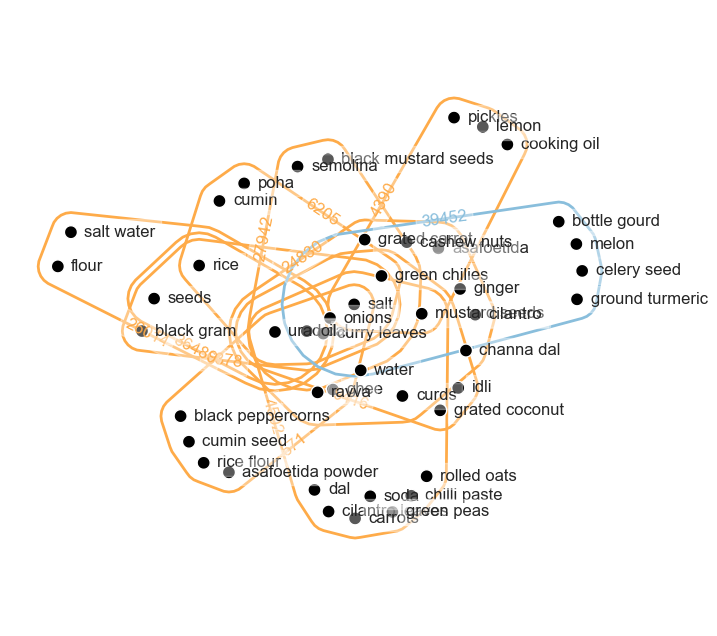

In [37]:
seleted_edges = dict((k,recipes_dict[k]) for k in annotated_plot.selected)
edge_colors = [color_key[recipes_label[k]] for k in annotated_plot.selected]
H = hnx.Hypergraph(seleted_edges)
hnx.drawing.draw(H,
                 edges_kwargs={
                     'edgecolors': edge_colors,
                     'linewidths': 2
                 })

In [32]:
# import gravis as gv
# import networkx as nx
# from networkx.algorithms import bipartite

# G = nx.Graph()
# G.add_nodes_from(ingredients, bipartite=0)
# G.add_nodes_from(list(range(n_recipes)), bipartite=1)
# edge_list = [(i, x) for i, rec in enumerate(recipes) for x in rec]
# G.add_edges_from(edge_list)
# nx.set_node_attributes(G, ingredients+recipes_label, "label")
# nx.set_node_attributes(G, [color_key['ingredient'] for x in ingredients]+[color_key[x] for x in recipes_label], "color")

# y = list(set([neigh for i in annotated_plot.selected for neigh in G.neighbors(i)]))
# H = nx.induced_subgraph(G, annotated_plot.selected+y).copy()